# Análise de dados: Pokémon 
Para conduzir uma análise em um conjunto de dados, deve-se, primeiramente, estabelecer as perguntas a serem respondidas, para então decidir quais testes e experimentos executar para derivar conclusões.

Nesta análise busca-se responder as seguintes perguntas:
1. O quanto os atributos revelam sobre o tipo de um pokémon?
2. É possível classificar um pokémon como lendário considerando apenas seus atributos?

### O quanto os atributos revelam sobre o tipo de um pokémon?


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
#Carrega banco descartando atributos sem influência para a primeira análise.
poke_db = pd.read_csv('Pokemon.csv').drop(['Type 2', 'Generation', 'Legendary','Total', '#'], axis = 1)
poke_db.head()

Populating the interactive namespace from numpy and matplotlib


,Name,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,45,49,49,65,65,45
1,Ivysaur,Grass,60,62,63,80,80,60
2,Venusaur,Grass,80,82,83,100,100,80
3,VenusaurMega Venusaur,Grass,80,100,123,122,120,80
4,Charmander,Fire,39,52,43,60,50,65


No gráfico abaixo, podemos visualizar como os atributos são distribuídos por tipo. A cor do elemento codifica o seu tipo, os eixos horizontal e vertical representam, respectivamente, os atributos e seus valores. 

Percebe-se que algumas regras podem ser derivadas a partir da análise do gráfico, como: nenhum pokémon do tipo inseto possui $HP > 100$. No entanto os atributos, em geral, aparentam estar balanceados.

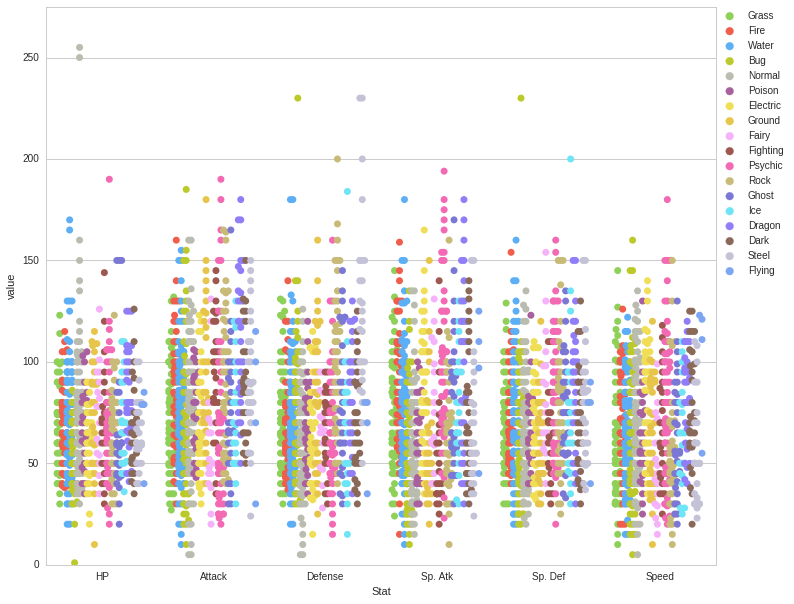

In [4]:
poke_db_attr = pd.melt(poke_db, id_vars=["Name", "Type 1"], var_name="Stat")
#poke_db_attr.head()
sns.set_style("whitegrid")
with sns.color_palette([
    "#8ED752", "#F95643", "#53AFFE", "#C3D221", "#BBBDAF",
    "#AD5CA2", "#F8E64E", "#F0CA42", "#F9AEFE", "#A35449",
    "#FB61B4", "#CDBD72", "#7673DA", "#66EBFF", "#8B76FF",
    "#8E6856", "#C3C1D7", "#75A4F9"], n_colors=18, desat=.9):
    plt.figure(figsize=(12,10))
    plt.ylim(0, 275)
    sns.swarmplot(x="Stat", y="value", data=poke_db_attr, hue="Type 1", split=True, size=7)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.);

Utilizamos Análise das Principais Componentes (PCA) para examinar melhor a estrutura da distribuição dos atributos em relação aos diferentes tipos, explicar como cada atributo se comporta e verificar se existe alguma segregação clara nos dados.

O gráfico abaixo consiste na projeção dos dados no plano formado pelas duas principais componentes, as quais maximizam a variância dos dados. As setas representam as direções em que os dados se deslocam em relação a cada atributo.

Podemos ver que os atributos são, de fato, bem balanceados em relação aos diferentes tipos, não apresentando tendências claras.

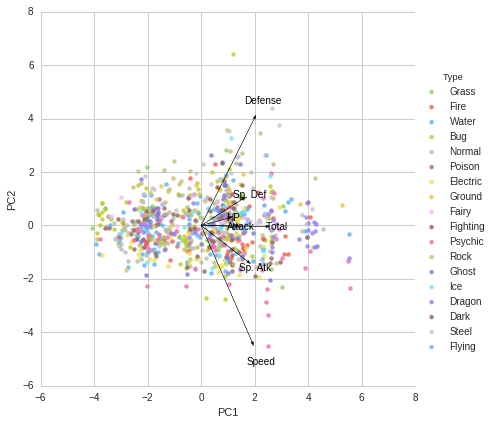

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

poke_db = pd.read_csv('Pokemon.csv').drop(['Type 2', '#'], axis = 1)
poke_db['Type1Id'] = poke_db['Type 1'].rank(method='dense').astype(int)

features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total']

poke_norm = poke_db.copy()

#Normalização necessária, pois o PCA maximiza a variância dos dados a qual é influenciada pela magnitude dos atributos.
poke_norm[features] = StandardScaler().fit(poke_db[features]).transform(poke_db[features])
pca = PCA(n_components=0.9)  
pca.fit(poke_norm[features])


pca_df = pd.DataFrame(pca.transform(poke_norm[features]))
pca_df.columns = ['PC'+str(i+1) for i in range(len(pca_df.columns))]

#Principais componentes para análise de direções.
loadings = pd.DataFrame(pca.components_, columns=features)
loadings.index = ['PC'+str(i+1) for i in range(len(pca_df.columns))]

pca_df['Type'] = poke_norm['Type 1']

with sns.color_palette([
        "#8ED752", "#F95643", "#53AFFE", "#C3D221", "#BBBDAF",
        "#AD5CA2", "#F8E64E", "#F0CA42", "#F9AEFE", "#A35449",
        "#FB61B4", "#CDBD72", "#7673DA", "#66EBFF", "#8B76FF",
        "#8E6856", "#C3C1D7", "#75A4F9"], n_colors=18, desat=.9):
            g = sns.lmplot(x='PC1', y='PC2', hue='Type', data=pca_df, fit_reg=False, size=6)
            g.set(ylim = (-6,8), xlim=(-6,8))
            for i in range(loadings.shape[1]):
                length = sqrt(loadings.iloc[0, i] ** 2 + loadings.iloc[1, i] ** 2)
                plt.arrow(0, 0, loadings.iloc[0, i]*length*9, loadings.iloc[1, i]*length*9, color='k', head_width=0.1, head_length=0.15)
                plt.text(loadings.iloc[0, i] * length * 10.5, loadings.iloc[1, i] * length * 10.5, loadings.columns.tolist()[i], color='k', ha='center', va='center')


No entanto, podemos notar uma diferença de densidade a partir da linha vertical $PC1 = 2$. Dadas as direções apontadas, podemos concluir que os pontos incidentes na região verde do gráfico abaixo correspondem aos pokémons com atributos superiores, e, dada a diferença de densidade, esse grupo deve ter alguma característica especial.

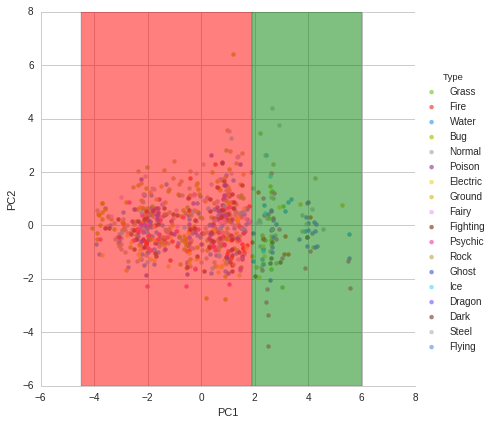

In [6]:
with sns.color_palette([
        "#8ED752", "#F95643", "#53AFFE", "#C3D221", "#BBBDAF",
        "#AD5CA2", "#F8E64E", "#F0CA42", "#F9AEFE", "#A35449",
        "#FB61B4", "#CDBD72", "#7673DA", "#66EBFF", "#8B76FF",
        "#8E6856", "#C3C1D7", "#75A4F9"], n_colors=18, desat=.9):
            g = sns.lmplot(x='PC1', y='PC2', hue='Type', data=pca_df, fit_reg=False, size=6)
            g.set(ylim = (-6,8), xlim=(-6,8))
            length = sqrt(loadings.iloc[0, i] ** 2 + loadings.iloc[1, i] ** 2)
            plt.axvspan(-4.50, 1.90, facecolor='r', alpha=0.5)
            plt.axvspan(1.90, 6.0, facecolor='g', alpha=0.5)
            


O gráfico abaixo representa em sua coloração as classes lendário e comum. Podemos ver que os atributos apontam fortes indícios sobre o fato de um pokémon ser, ou não, lendário.




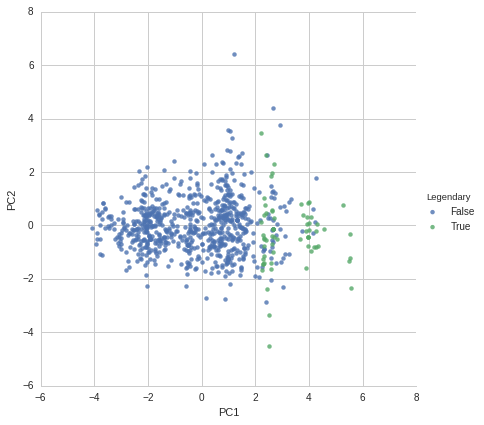

In [7]:
pca_df['Legendary'] = [True if p > 0 else False for p in poke_norm['Legendary']]
g = sns.lmplot(x='PC1', y='PC2', hue='Legendary', data=pca_df, fit_reg=False, size=6)

Em busca de uma melhor compreensão da estrutura dos dados, aplicamos o algoritmo t-SNE (Stochastic Neighbourhood Embedding), que funciona estimando distrituições (t-student) que representam a vizinhança de cada instância com base na distância euclidiana. 

Podemos ver que os dois grupos são claramente distintos. No entanto, esse gráfico foi gerado tendo em posse a *feature* que queremos inferir (Lendário). 

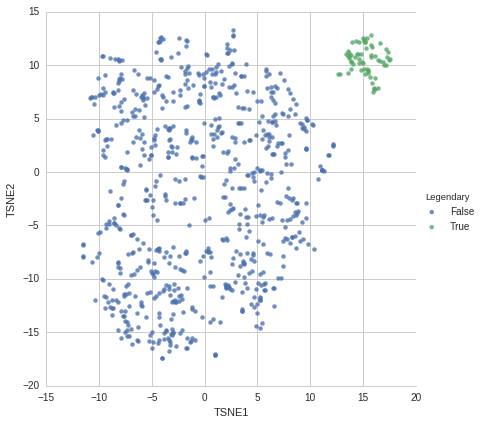

In [8]:
from sklearn.manifold import TSNE

features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total', 'Type1Id', 'Legendary']

#Normalização necessária, pois o t-SNE codifica distância euclidiana, métrica afetada pela magnitude.
poke_norm[features] = StandardScaler().fit(poke_db[features]).transform(poke_db[features])
tsne = TSNE(learning_rate=700, n_components=2).fit_transform(poke_norm[features])
tsne_df = pd.DataFrame(tsne)
tsne_df.columns = ['TSNE'+str(i+1) for i in range(len(tsne_df.columns))]
tsne_df['Legendary'] = [True if p > 0 else False for p in poke_norm['Legendary']]
sns.lmplot(x='TSNE1', y='TSNE2', hue='Legendary', data=tsne_df, fit_reg=False, size=6)


Aplicando o mesmo algoritmo, agora sem a *feature* Lendário, podemos ver que, apesar de não tão distintos, os grupos ainda aparentam ter características diferentes. 

Obs: O algoritmo é estocástico. Portanto, produz saídas diferentes, dependendo da execução. É possível que uma saída exemplifique melhor do que outra. 

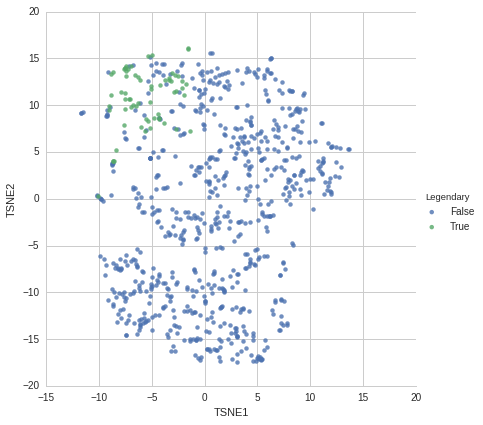

In [9]:
#Remoção do feature 'Legacy'
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Type1Id', 'Total']

#Normalização necessária, pois o t-SNE codifica distância euclidiana, métrica afetada pela magnitude.
poke_norm[features] = StandardScaler().fit(poke_db[features]).transform(poke_db[features])

tsne = TSNE(learning_rate=700, n_components=2).fit_transform(poke_norm[features])
tsne_df = pd.DataFrame(tsne)
tsne_df.columns = ['TSNE'+str(i+1) for i in range(len(tsne_df.columns))]
tsne_df['Legendary'] = [True if p > 0 else False for p in poke_norm['Legendary']]
sns.lmplot(x='TSNE1', y='TSNE2', hue='Legendary', data=tsne_df, fit_reg=False, size=6)


### É possível classificar um pokémon como lendário considerando apenas seus atributos?

Dada a análise acima, nota-se que os atributos apresentam fortes indícios sobre a *feature* Lendário. Logo, treinaremos um classificador para predizer, baseando-se apenas nos atributos, se um pokémon é lendário ou não.

Com base na análise, as regiões podem ser efetivamente separadas utilizando uma reta. Portanto, utilizaremos como classificador uma SVM de kernel linear. Como conjunto de treinamento, utilizaremos apenas $15\%$ dos dados.

Em nosso modelo utilizaremos como *features* as coordenadas dos dois principais componentes encontrados pela decomposição PCA.

Foi escolhido o classificador SVM por conta de sua intuitiva visualização. Não serão necessárias etapas de validação cruzada, pois a análise dos dados em duas dimensões foi capaz de sugerir um modelo que se adeque bem. No entanto, ressaltamos que este não necessariamente (e provavelmente não) é o melhor modelo possível para classificação desses dados, restando inúmeras transformações e/ou diferentes *features* a serem exploradas.


In [31]:
from sklearn import svm
import numpy as np

total_positive = sum(pca_df['Legendary'])
total_negative = pca_df.shape[0] - total_positive

trainning_slice = 0.15 #utiliza 15% dos dados como treinamento.
n_positive = int(total_positive * trainning_slice)
n_negative = int(total_negative * trainning_slice)

#Define Target
#pca_df['Target'] = pca_df['Legendary']

#extrai o conjunto aleatoriamente.
shuffle_pca_df = pca_df.iloc[np.random.permutation(pca_df.shape[0])]
shuffle_pca_df.head()

#monta o conjunto de treino e teste.
trainning = shuffle_pca_df.loc[shuffle_pca_df['Legendary'] == True].iloc[0:n_positive]
trainning = trainning.append(shuffle_pca_df.loc[shuffle_pca_df['Legendary'] == False].iloc[0:n_negative])
trainning['Target'] = [1 if p > 0 else -1 for p in trainning['Legendary']]

testing = shuffle_pca_df.loc[shuffle_pca_df['Legendary'] == True].iloc[n_positive:]
testing = testing.append(shuffle_pca_df.loc[shuffle_pca_df['Legendary'] == False].iloc[n_negative:])
testing['Target'] = [1 if p > 0 else -1 for p in testing['Legendary']]


Para treinamento, utilizaremos, como dito anteriormente, uma SVM de kernel linear. Como a distribuição de exemplos positivos e negativos é desbalanceada (quantidade bem maior de exemplos negativos), atribuímos um peso maior aos erros cometidos em relação à classe Lendários.

O gráfico mostra as regiões de decisão computadas pelo algoritmo. A classe Comum é atribuida para pontos incidentes na região azul e a classe Lendária é atribuída para pontos incidentes na região vermelha. Ressaltamos também que a escolha do conjunto de treinamento é estocástica, portanto, o classificador pode ter um desempenho melhor, ou pior, dependendo das amostras de teste. Esta variância diminui com o aumento do tamanho do conjunto de treinamento, porém, no caso médio apresenta um bom desempenho.

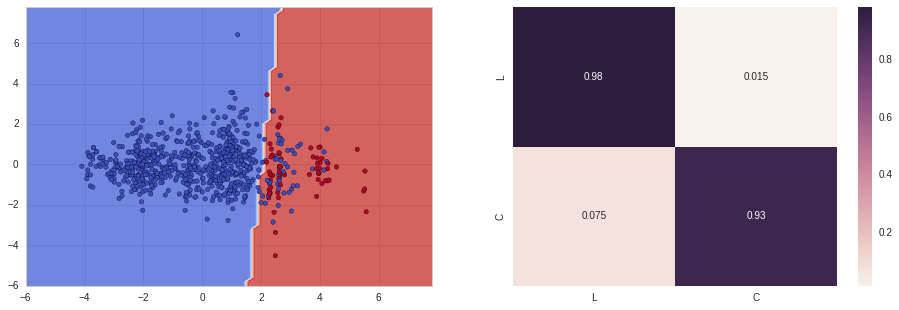

In [32]:
C = 1.0
weights = total_negative/total_positive
clf = svm.SVC(kernel='linear', C=C, class_weight={1: weights})
Components = ['PC1', 'PC2']
clf.fit(trainning[Components], trainning['Target'])

legendary_pca = pca_df.loc[pca_df['Legendary'] == True]
legendary_out = clf.predict(legendary_pca[Components])

common_pca = pca_df.loc[pca_df['Legendary'] == False]
common_out = clf.predict(common_pca[Components])

confusion = [
    [sum(legendary_out == 1)/len(legendary_out), sum(legendary_out == -1)/len(legendary_out)],
    [sum(common_out == 1) /len(common_out), sum(common_out == -1)/len(common_out)]
]


#Função para plotar regiões de decisão e matriz de confusão.
def plot_db_cm(clf, confusion, data):

    df_cm = pd.DataFrame(confusion, index = [i for i in "LC"],
                      columns = [i for i in "LC"])

    f = plt.figure(figsize=(16,5))
    ax = f.add_subplot(121)
    h = 0.2
    xx, yy = np.meshgrid(np.arange(-6, 8, h),
                         np.arange(-6, 8, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(data['PC1'], data['PC2'], c=data['Legendary'], cmap=plt.cm.coolwarm)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax2 = f.add_subplot(122)
    sns.heatmap(df_cm, annot=True,ax = ax2)

plot_db_cm(clf, confusion, shuffle_pca_df)



Abaixo, um SVM que utiliza funções de base radial como kernel, para fins de ilustração.

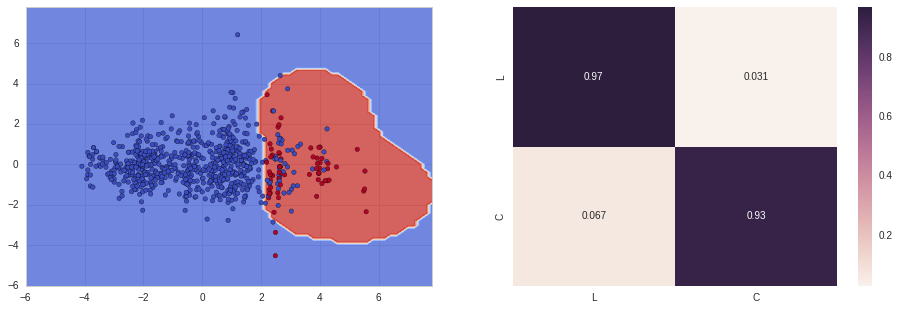

In [33]:
clf = svm.SVC(kernel='rbf', C=C, gamma = 0.2, class_weight={1: weights})
clf.fit(trainning[Components], trainning['Target'])

legendary_pca = pca_df.loc[pca_df['Legendary'] == True]
legendary_out = clf.predict(legendary_pca[Components])

common_pca = pca_df.loc[pca_df['Legendary'] == False]
common_out = clf.predict(common_pca[Components])

confusion = [
    [sum(legendary_out == 1)/len(legendary_out), sum(legendary_out == -1)/len(legendary_out)],
    [sum(common_out == 1) /len(common_out), sum(common_out == -1)/len(common_out)]
]

plot_db_cm(clf, confusion, shuffle_pca_df)


## Conclusões
### 1. O quanto os atributos revelam sobre o tipo de um pokémon?
Os atributos de um pokémon parecem não caracterizar o seu tipo, salvo algumas exceções (como a mencionada no início da análise). Em geral, pode-se considerar que os atributos estão bem balanceados dentre os diferentes tipos. Pouca informação sobre o tipo de um pokémon é revelada por seus atributos. Apesar de que uma análise mais precisa poderia ser feita analisando a Informação Mútua entre os atributos e a variável de tipo.
### 2. É possível classificar um pokémon como lendário considerando apenas seus atributos?
Sim, a classe Lendária apresenta uma combinação de atributos distinta da grande maioria nas transformações experimentadas (PCA, t-SNE), o que permite a predição, mesmo utilizando um modelo simples.